## Merging Data

In [22]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# pip install pyBigWig
import pyBigWig

In [23]:
#merge data together 
cv_df = pd.read_csv("../data/causal_variance_snps.csv")
hdf = pd.read_csv("../data/heritability_scores.csv")

df = pd.merge(cv_df, hdf, how="inner", left_on="GeneID", right_on="TargetID")[['GeneID', 'NumCausalSNPs', 'Heritability_Score', 'Chromosome_y', 'CausalVariance']]
df.columns = ['GeneID', 'NumCausalSNPs', 'Heritability', 'Chr', 'CV']
df.head()

,GeneID,NumCausalSNPs,Heritability,Chr,CV
0,ENSG00000177757,0.0,0.380509,1,0.0
1,ENSG00000225880,0.0,0.339431,1,0.0
2,ENSG00000228794,0.0,0.000000,1,0.0
3,ENSG00000188976,0.0,0.062799,1,0.0
4,ENSG00000187961,0.0,0.260974,1,0.0


In [4]:
# group into 4 categories

conditions = [
    (df['Heritability'] >= 0.4) & (df['NumCausalSNPs'] < 3), 
    (df['Heritability'] >= 0.4) & (df['NumCausalSNPs'] >= 3), 
    (df['Heritability'] < 0.4) & (df['NumCausalSNPs'] < 3),   
    (df['Heritability'] < 0.4) & (df['NumCausalSNPs'] >= 3)   
]
labels = [
    'Large Heritablity, Few causal SNPs',
    'Large Heritablity, Many causal SNPs',
    'Small Heritablity, Few causal SNPs',
    'Small Heritablity, Many causal SNPs'
]
df['Category'] = np.select(conditions, labels, default='Uncategorized')
grouped_df = df.groupby('Category').size().reset_index(name='Count')
grouped_df

,Category,Count
0,"Large Heritablity, Few causal SNPs",612
1,"Large Heritablity, Many causal SNPs",17
2,"Small Heritablity, Few causal SNPs",12389
3,"Small Heritablity, Many causal SNPs",257


In [5]:
## chi square test
from scipy.stats import chi2_contingency

contingency_table = np.array([[612, 17],
                              [12389, 257]])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")


Chi-square statistic: 1.0213604532758824
P-value: 0.31219652304761014


/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_99950/4089699029.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('HeritabilityBin')['NumCausalSNPs'].mean().reset_index()


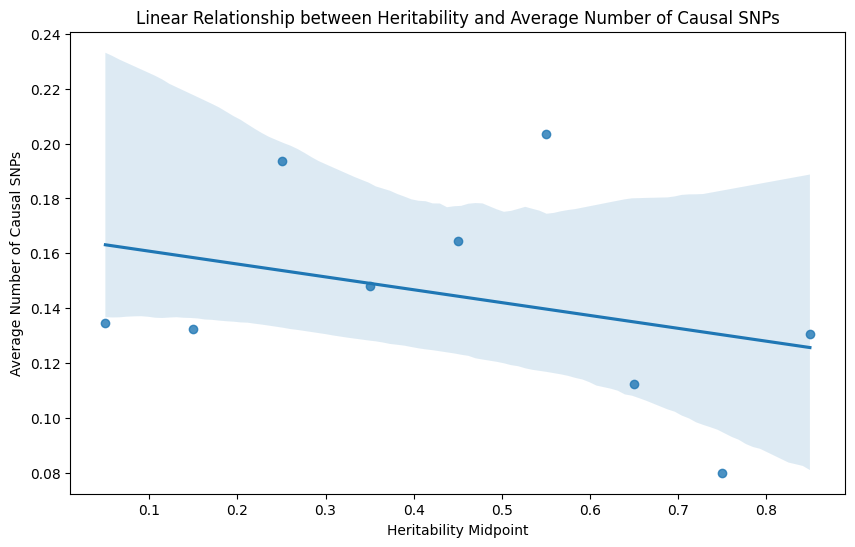

In [6]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']
df['HeritabilityBin'] = pd.cut(df['Heritability'], bins=bins, labels=labels, include_lowest=True)
grouped = df.groupby('HeritabilityBin')['NumCausalSNPs'].mean().reset_index()
grouped['HeritabilityMidpoint'] = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
# Plot 
plt.figure(figsize=(10, 6))
sns.regplot(x='HeritabilityMidpoint', y='NumCausalSNPs', data=grouped)
plt.xlabel('Heritability Midpoint')
plt.ylabel('Average Number of Causal SNPs')
plt.title('Linear Relationship between Heritability and Average Number of Causal SNPs')
plt.show()


# Causal Variance EDA

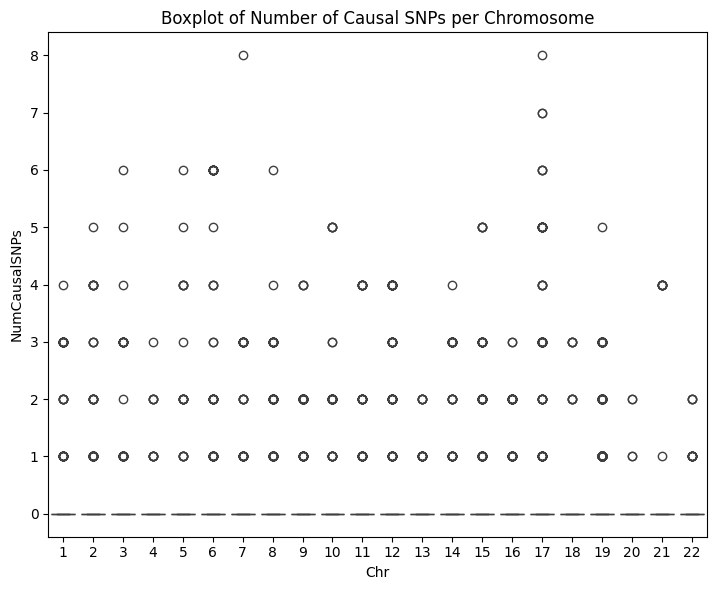

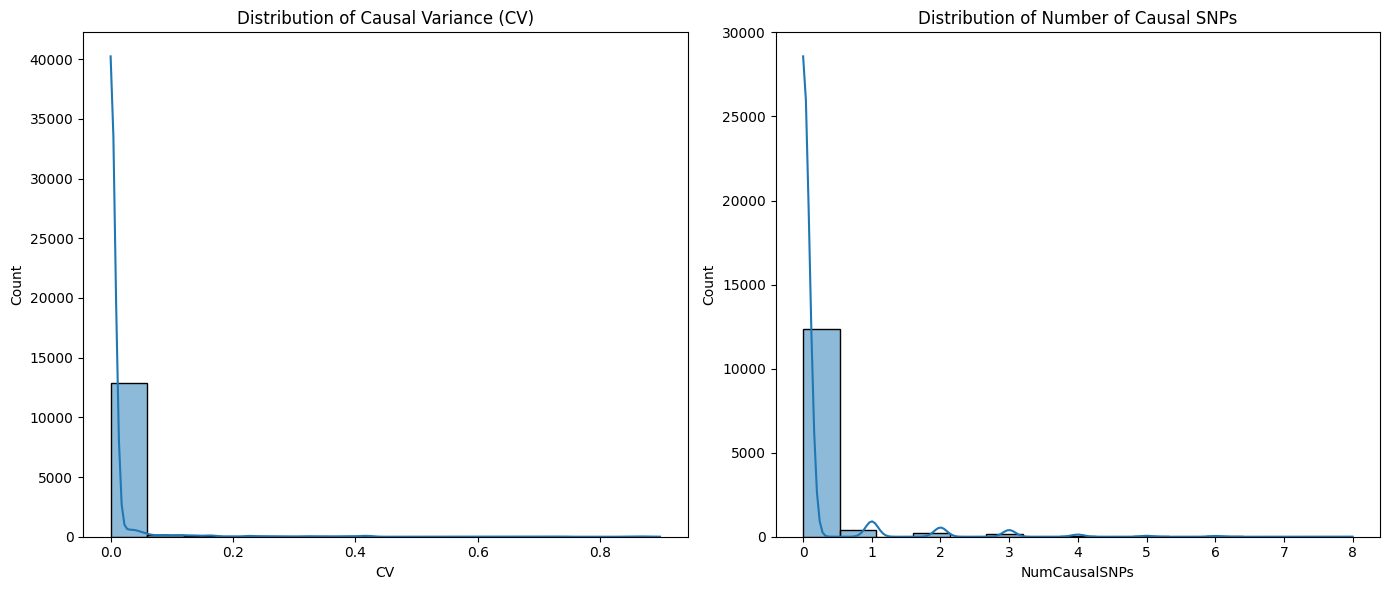

In [7]:
gene_annotation = pd.read_csv("../data/gene_annotation.txt", sep="\t")
ldf = pd.merge(df, gene_annotation, how="inner", left_on="GeneID", right_on="SYM")
# Low number of causal snps combined with high causal variance 
gdf = df.groupby("Chr")[['CV', 'NumCausalSNPs']].mean().reset_index()

#boxplot

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Chr', y='NumCausalSNPs', data=df)
plt.title('Boxplot of Number of Causal SNPs per Chromosome')
plt.tight_layout()
plt.show()

#distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['CV'], kde=True)
plt.title('Distribution of Causal Variance (CV)')
plt.subplot(1, 2, 2)
sns.histplot(df['NumCausalSNPs'], kde=True)
plt.title('Distribution of Number of Causal SNPs')
plt.tight_layout()
plt.show()

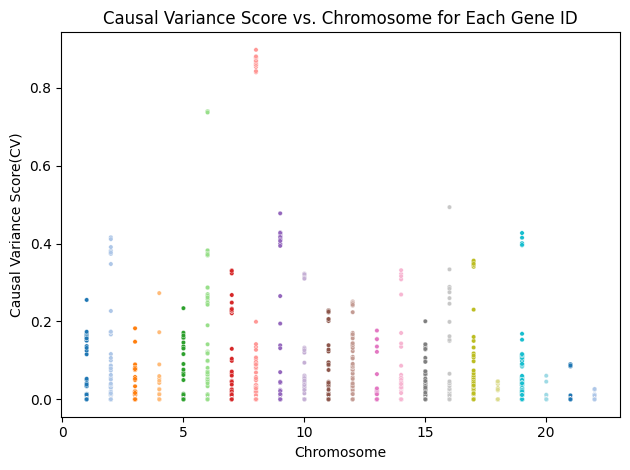

In [8]:
sns.scatterplot(data=df, x='Chr', y='CV', hue='Chr', palette='tab20', s=10, legend=False) 
plt.xticks(rotation=0) # Sets the rotation of the chromosome labels
plt.title('Causal Variance Score vs. Chromosome for Each Gene ID')
plt.xlabel('Chromosome')
plt.ylabel('Causal Variance Score(CV)')
plt.tight_layout() 
plt.show()

## GERP Scores

They are associated by position so merge the original gene ids with coordinates and ranges

In [24]:
bw = pyBigWig.open("../data/All_hg19_RS.bw")
gene_annotation = pd.read_csv("../data/gene_annotation.txt", sep="\t")
df = pd.merge(df, gene_annotation, how="inner", left_on="GeneID", right_on="SYM")
df['CHR'] = df['CHR'].astype(str)

In [10]:
def get_gerp_score(start, stop, chromo):
    try:
        chromo = "chr" + chromo 
        scores = bw.values(chromo, int(start), int(stop))
        scores = [score for score in scores if score is not None]
        return sum(scores) / len(scores) if scores else None
    except Exception as e:
        print(f"Error processing row: start={start}, stop={stop}, chromo={chromo}, Error: {e}")
        return None

df['GERP Score'] = df.apply(lambda row: get_gerp_score(row['START'], row['STOP'], row['CHR']), axis=1)
bw.close()


Error processing row: start=197960199, stop=198043720, chromo=chr3, Error: Invalid interval bounds!
Error processing row: start=198152365, stop=198199015, chromo=chr3, Error: Invalid interval bounds!
Error processing row: start=181040224, stop=181061523, chromo=chr5, Error: Invalid interval bounds!
Error processing row: start=81189592, stop=81222999, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81228276, stop=81239091, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81239238, stop=81241281, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81244999, stop=81295547, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81509970, stop=81523847, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81528395, stop=81537130, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=63034216, stop=63037028, chromo=chr20, Error: Invalid interval bounds!
Error p

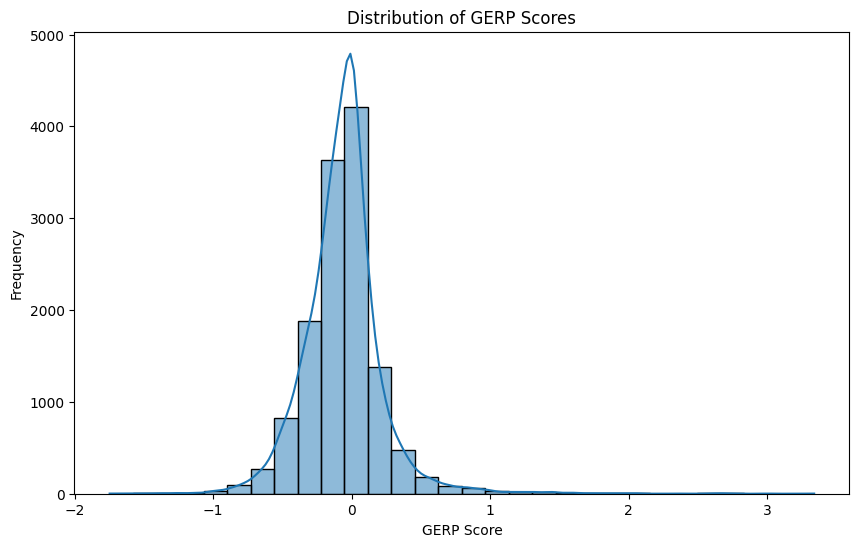

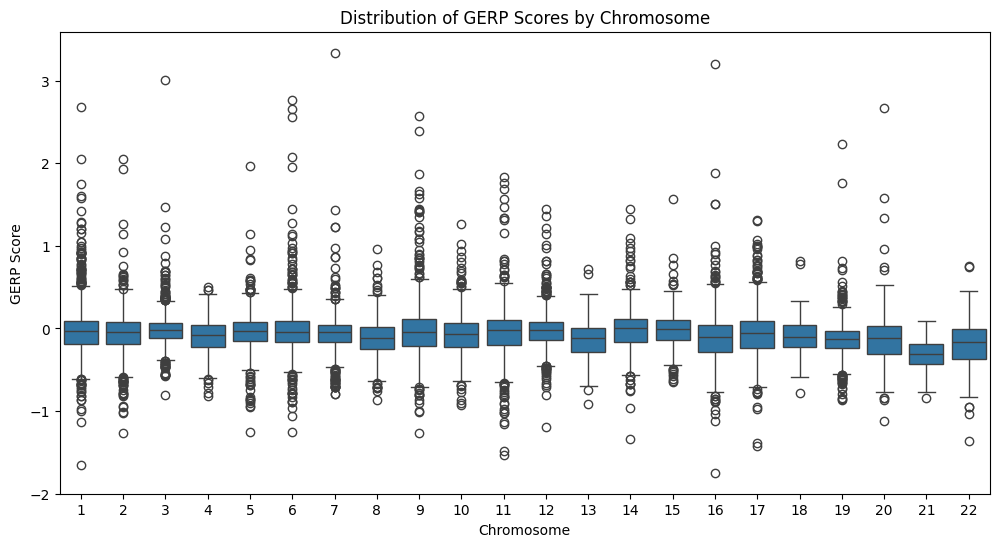

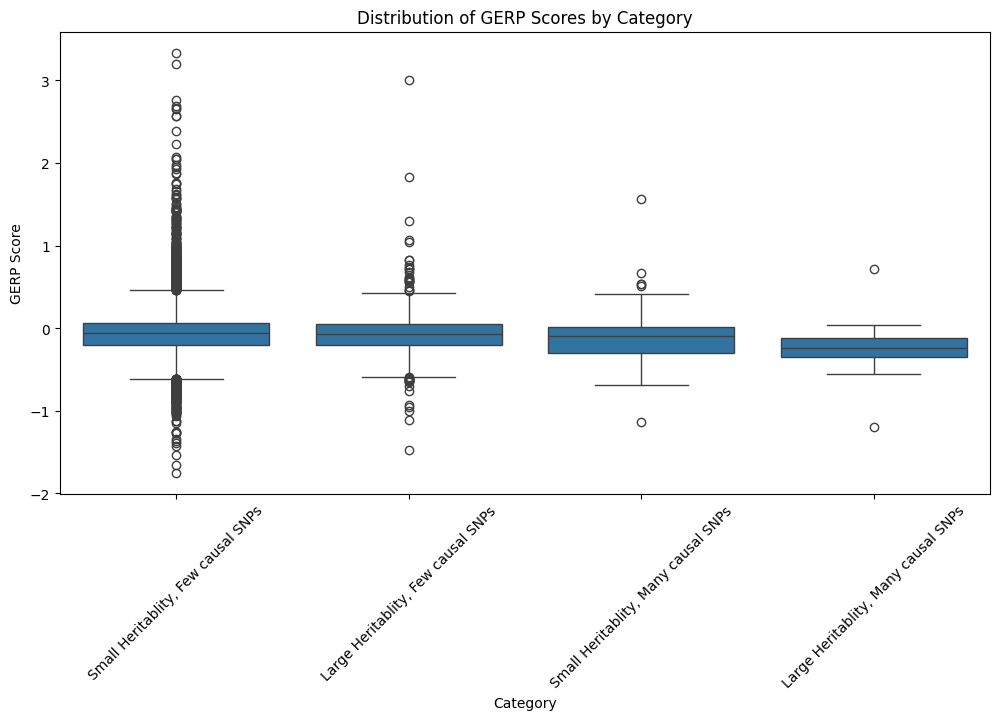

In [12]:
# dist 
plt.figure(figsize=(10, 6))
sns.histplot(df['GERP Score'], bins=30, kde=True)
plt.title('Distribution of GERP Scores')
plt.xlabel('GERP Score')
plt.ylabel('Frequency')
plt.show()

# by chr
plt.figure(figsize=(12, 6))
sns.boxplot(x='Chr', y='GERP Score', data=df)
plt.title('Distribution of GERP Scores by Chromosome')
plt.xlabel('Chromosome')
plt.ylabel('GERP Score')
plt.show()

# by cat 
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='GERP Score', data=df)
plt.title('Distribution of GERP Scores by Category')
plt.xticks(rotation=45)  
plt.xlabel('Category')
plt.ylabel('GERP Score')
plt.show()

In [16]:
gerp_grouped_df = df.groupby("Category")[['GERP Score']].mean().reset_index()
gerp_grouped_df

,Category,GERP Score
0,"Large Heritablity, Few causal SNPs",-0.063798
1,"Large Heritablity, Many causal SNPs",-0.251407
2,"Small Heritablity, Few causal SNPs",-0.060510
3,"Small Heritablity, Many causal SNPs",-0.117523


In [21]:
import scipy.stats as stats

bins = [-1, -0.33, 0.33, 1]
labels = ['Low', 'Medium', 'High']
df['GERP Category'] = pd.cut(df['GERP Score'], bins=bins, labels=labels)

contingency_table = pd.crosstab(df['Category'], df['GERP Category'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2}")
print(f"P-value: {p}")



Chi-square statistic: 12.355967926598327
P-value: 0.054482739417963756


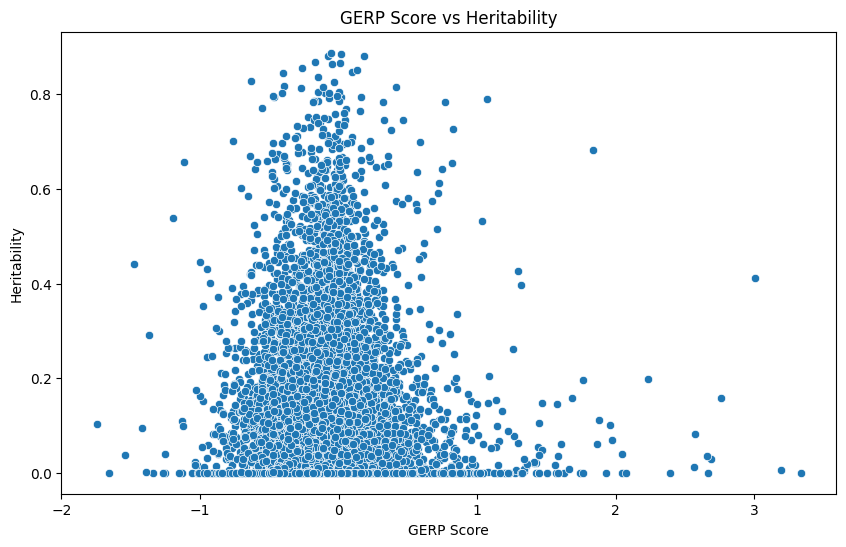

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GERP Score', y='Heritability', data=df)
plt.title('GERP Score vs Heritability')
plt.show()

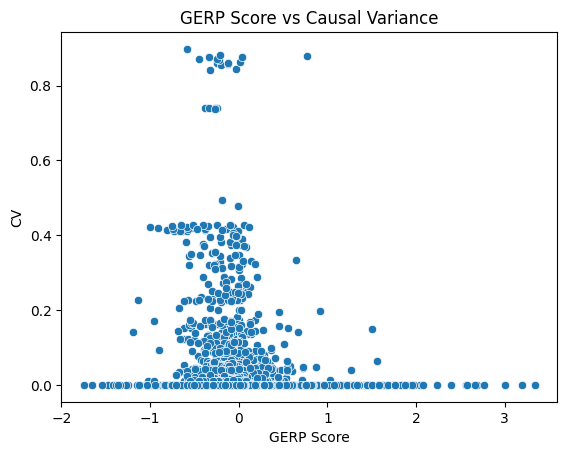

In [40]:
sns.scatterplot(x='GERP Score', y='CV', data=df)
plt.title('GERP Score vs Causal Variance')
plt.show()

In [46]:
df.groupby("Category")[['GERP Score']].mean()

,GERP Score
Category,
"Large Heritablity, Few causal SNPs",-0.063798
"Large Heritablity, Many causal SNPs",-0.251407
"Small Heritablity, Few causal SNPs",-0.060510
"Small Heritablity, Many causal SNPs",-0.117523
